# Изучение пользоваетелей сервиса проката самокатов GoFast

## Описание проекта

Закзчик исследования популярный сервиса аренды самокатов GoFast. Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
* без подписки
  * абонентская плата отсутствует;
  * стоимость одной минуты поездки — 8 рублей;
  * стоимость старта (начала поездки) — 50 рублей;
* с подпиской Ultra
  * абонентская плата — 199 рублей в месяц;
  * стоимость одной минуты поездки — 6 рублей;
  * стоимость старта — бесплатно.



## Описание данных

В основных данных есть информация о пользователях, их поездках и подписках.

Пользователи — **users_go.csv**

* ***user_id*** -	уникальный идентификатор пользователя
* ***name*** -	имя пользователя
* ***age*** -	возраст
* ***city*** -	город
* ***subscription_type*** -	тип подписки (*free*, *ultra*)

Поездки — **rides_go.csv**
* ***user_id*** -	уникальный идентификатор пользователя
* ***distance*** -	расстояние, которое пользователь проехал в текущей сессии (в метрах)
* ***duration*** -	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* ***date***	- дата совершения поездки

Подписки — **subscriptions_go.csv**
* ***subscription_type*** -	тип подписки
* ***minute_price***	- стоимость одной минуты поездки по данной подписке
* ***start_ride_price*** -	стоимость начала поездки
* **subscription_fee**	- стоимость ежемесячного платежа

# Шаг 1. Загрузка данных

Импортируем необходимые библиотеки:

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

Считаем CSV-файлы с данными с помощью библиотеки pandas и сохраняем их в датафреймы:

In [104]:
try:
    users_go = pd.read_csv('users_go.csv')
    rides_go = pd.read_csv('rides_go.csv')
    subscriptions_go = pd.read_csv('subscriptions_go.csv')
except:
    users_go = pd.read_csv('/datasets/users_go.csv')
    rides_go = pd.read_csv('/datasets/rides_go.csv')
    subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')

Далее выводим общую информацию по всем трём датафреймам:

In [105]:
print(users_go.info())
print(rides_go.info())
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns)

Также посмотрим на первые строки каждого из них:

In [106]:
users_go.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [107]:
rides_go.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [108]:
subscriptions_go.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Можем сделать первоначальный вывод по данным: видим, что наполненней всего датафрейм с данными о поездках, что вполне логично; также можно отметить, что в данных пока не заметно пропущенных значений, а также все типы данных для столбцов соответствующие.

# Шаг 2. Предобработка данных

Первым делом приведём стобец ***data*** из датафрейма **rides_go** к корректному типу данных:

In [109]:
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y.%m.%d')
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Добавим в датафрейм отдельный столбец ***date_month*** с данными о месяце, когда была совершена поездка:

In [110]:
rides_go['date_month'] = pd.DatetimeIndex(rides_go['date']).month
rides_go.head()

,user_id,distance,duration,date,date_month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Построим линейный график, чтобы посмотреть, за какой именно период у нас предоставлены данные:

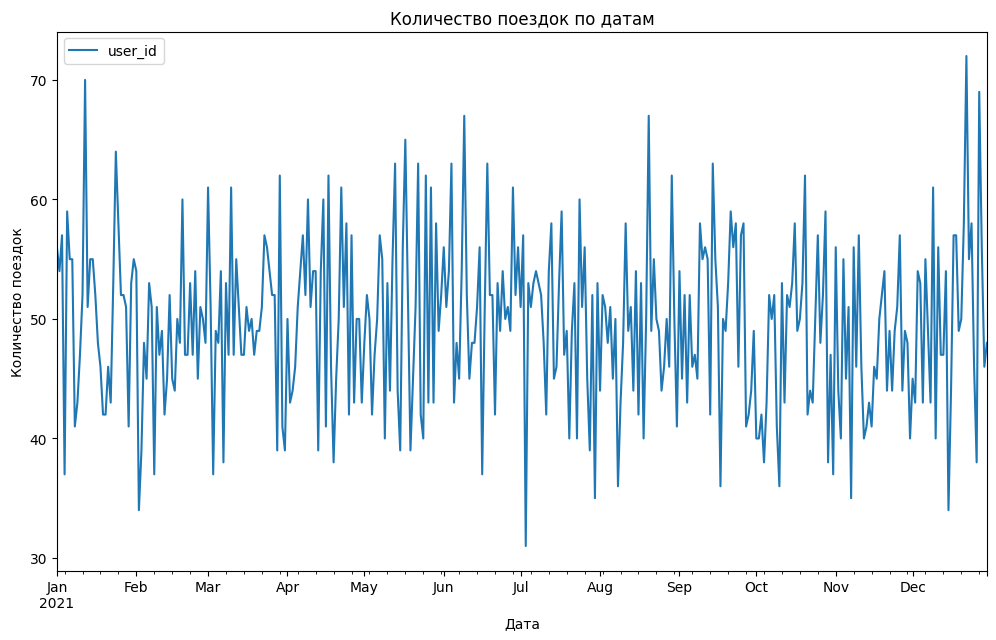

In [111]:
rides_go.pivot_table(index='date', values='user_id', aggfunc='count').plot(kind='line', figsize=(12,7))
plt.title('Количество поездок по датам')
plt.xlabel('Дата')
plt.ylabel('Количество поездок')
plt.show()

Видим, что среди данных у нас только 2021 год с января по декабрь.

 Теперь проверим данные на наличие пропусков и дубликатов. В первоначальной общей информации о датафреймах не было замечено пропусков, но проверим датафреймы ещё раз:

In [112]:
print(users_go.isna().sum())
print(rides_go.isna().sum())
print(subscriptions_go.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
user_id       0
distance      0
duration      0
date          0
date_month    0
dtype: int64
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


Видим, что пропущенных значений нет ни в одном из датафреймов. Переходим к дубликатам.

Сначала проверим на дубликаты датафрейм **rides_go**:

In [113]:
rides_go.duplicated().sum()

0

В этом датафрейме дубликаты не найдены. Теперь проверим их наличие в датафрейме **users_go**:

In [114]:
users_go.duplicated().sum()

31

Удаляем явные дубликаты и проверяем:

In [115]:
users_go.drop_duplicates(inplace=True)
users_go.duplicated().sum()

0

Промежуточный вывод по предобработке: добавили новый столбец с данными месяцев поездок каждого пользователя для удобства дальнейший расчётов; выявили отсутствие пропусков в датафреймах; избавились от дубликатов в датафрейме **users_go**. Далее можем приступать к исследовательскому анализу данных.

# Шаг 3. Исследовательский анализ данных

В начале посмотрим, на частоту встречаемости городов в наших данных:

In [116]:
users_go['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

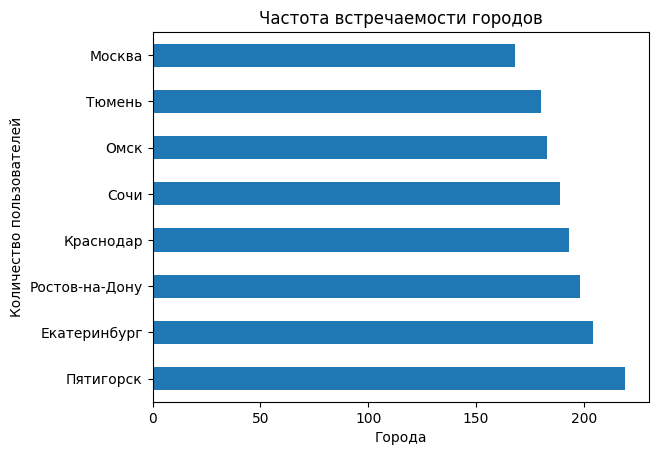

In [117]:
users_go['city'].value_counts().plot(kind='barh')
plt.title('Частота встречаемости городов')
plt.xlabel('Города')
plt.ylabel('Количество пользователей')
plt.show()

Можем видеть, что большая часть пользователей их нашей выборки находится в Пятигорске, Екатеринбурге и Ростове-на-Дону. Как ни странно, меньше всего пользоветелей из Москвы.

Далее рассмотрим процентное соотношение пользователей с подпиской и без подписки:

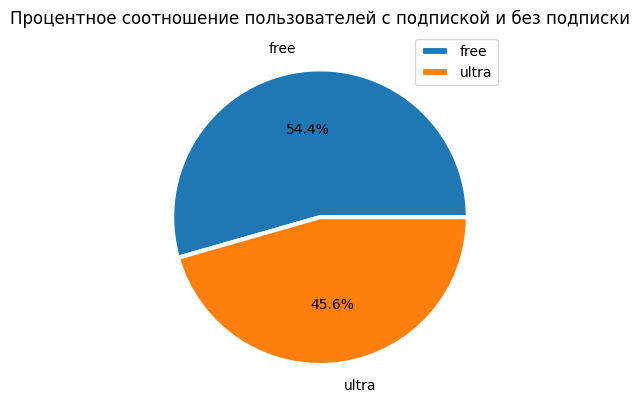

In [118]:
subscription_type = users_go['subscription_type'].value_counts()
plt.pie(subscription_type,
        labels=subscription_type.index,
        autopct='%1.1f%%',
        labeldistance=1.15,
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.title('Процентное соотношение пользователей с подпиской и без подписки')
plt.legend()
plt.show()

Категории пользователей поделились почти поровну, но без подписки их всё-таки больше (54.1%).

Посмотрим на распрделение возраста пользователей в данных:

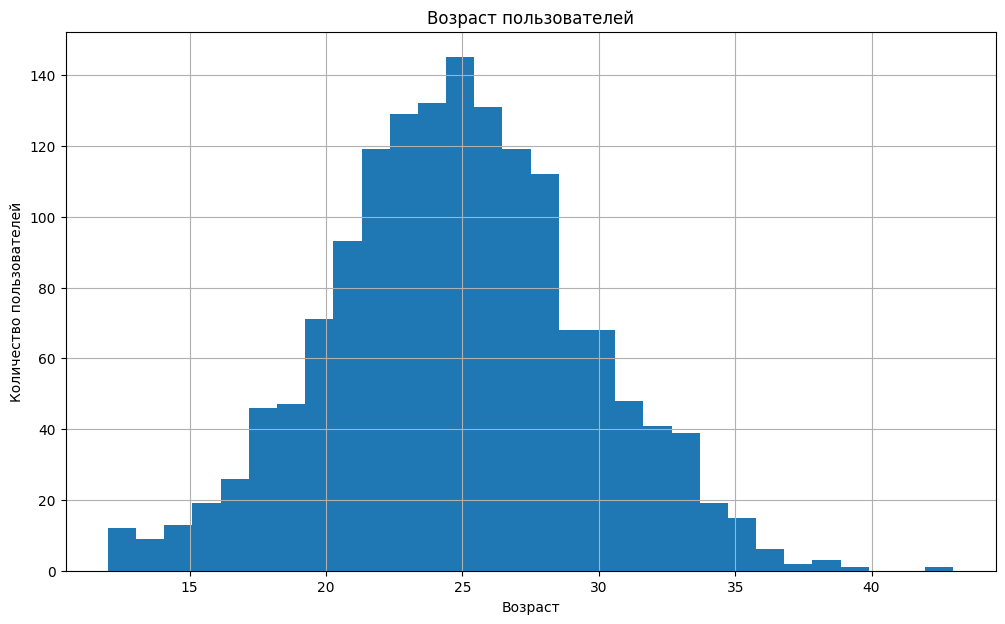

In [119]:
users_go['age'].hist(bins=30, figsize=(12,7))
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

Данные имеют нормальное распределение с пиковым значением 25 лет, что говорит нам о том, что молодёжь (23 - 27 лет) пользуется нашим сервисом чаще, чем остальные возрастные категории.

Теперь посмотрим, сколько в срденем состовляет расстояние одной поездки:

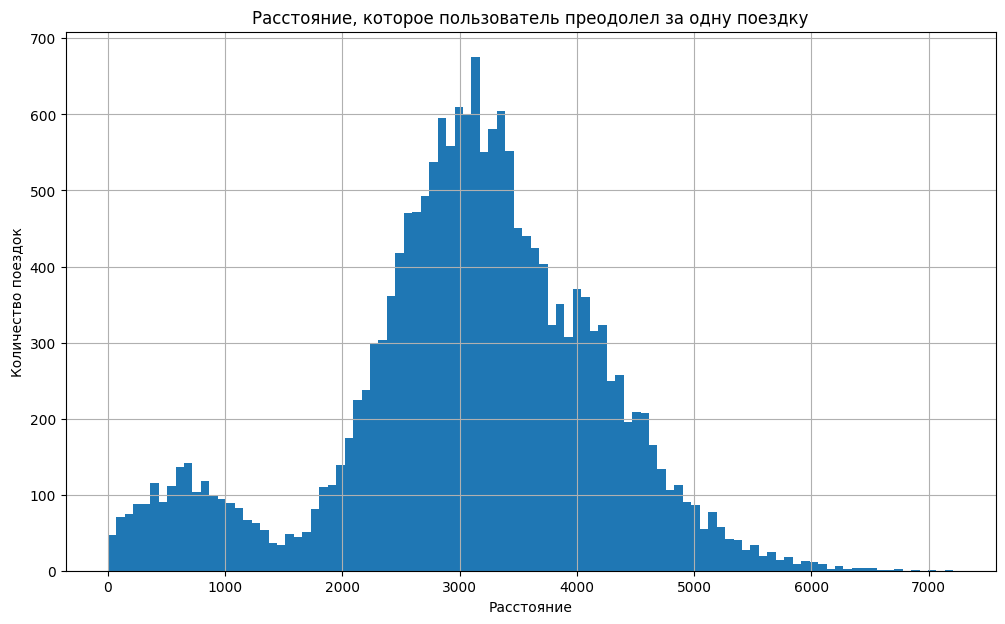

In [120]:
rides_go['distance'].hist(bins=100, figsize=(12,7))
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

На основе данных у нас образовалось нормальное распределение с двумя пиковыми значениями: первое - 600-800 метров за одну поездку, второе - 2700-3200 метров. Второй пик значительно выше, из чего можно сделать вывод, что наши самокаты используют чаще для бОльшего расстояния.

Далее взглянем на продолжительность поездок:

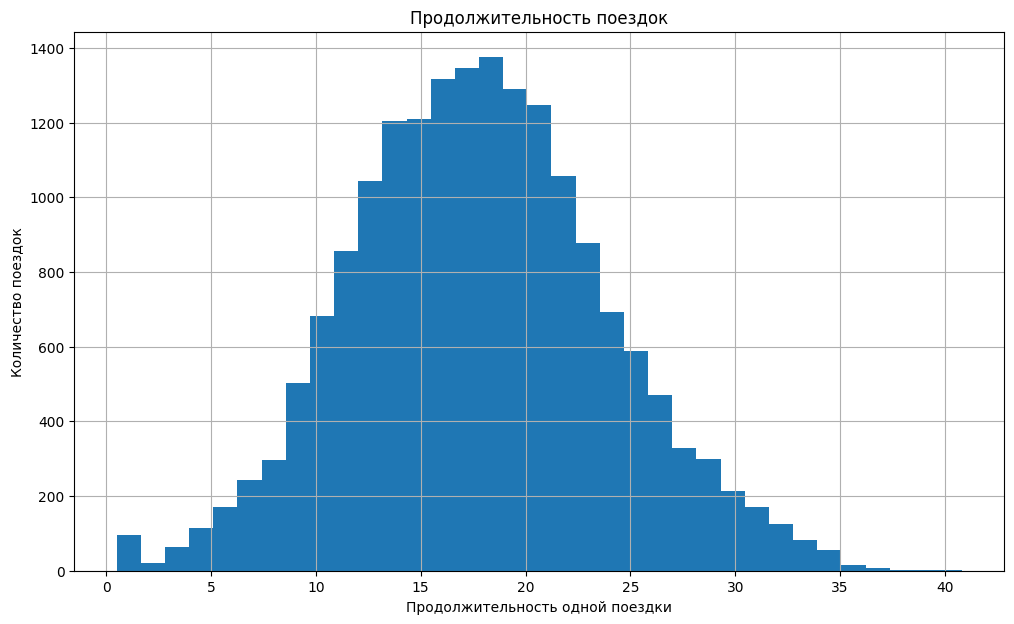

In [121]:
rides_go['duration'].hist(bins=35, figsize=(12,7))
plt.title('Продолжительность поездок')
plt.xlabel('Продолжительность одной поездки')
plt.ylabel('Количество поездок')
plt.show()

Здесь также наблюдаем нормальное распределение с пиковым значение 15 - 20 минут.

# Шаг 4. Объединение данных

Объединим все наши датафреймы в один с помощью метода *merge*:

In [122]:
users_and_rides_go = rides_go.merge(users_go, on='user_id', how='inner')
data = users_and_rides_go.merge(subscriptions_go, on='subscription_type', how='inner')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   date_month         18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Посмотрим на первые строки общего датафрейма и оценим результат объединения:

In [123]:
data.head()

,user_id,distance,duration,date,date_month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Теперь разделим общий датафрейм на два - пользователи с подпиской и без подписки:

In [124]:
free = data[data['subscription_type'] == 'free']
ultra = data[data['subscription_type'] == 'ultra']

In [125]:
print(free.info())
print(ultra.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   distance           11568 non-null  float64       
 2   duration           11568 non-null  float64       
 3   date               11568 non-null  datetime64[ns]
 4   date_month         11568 non-null  int64         
 5   name               11568 non-null  object        
 6   age                11568 non-null  int64         
 7   city               11568 non-null  object        
 8   subscription_type  11568 non-null  object        
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB
None
<class 'pandas.core.frame.DataFr

Сравним показатели двух категорий (пользователей с подпиской и без) по расстоянию и затраченному времени для одной поездки:

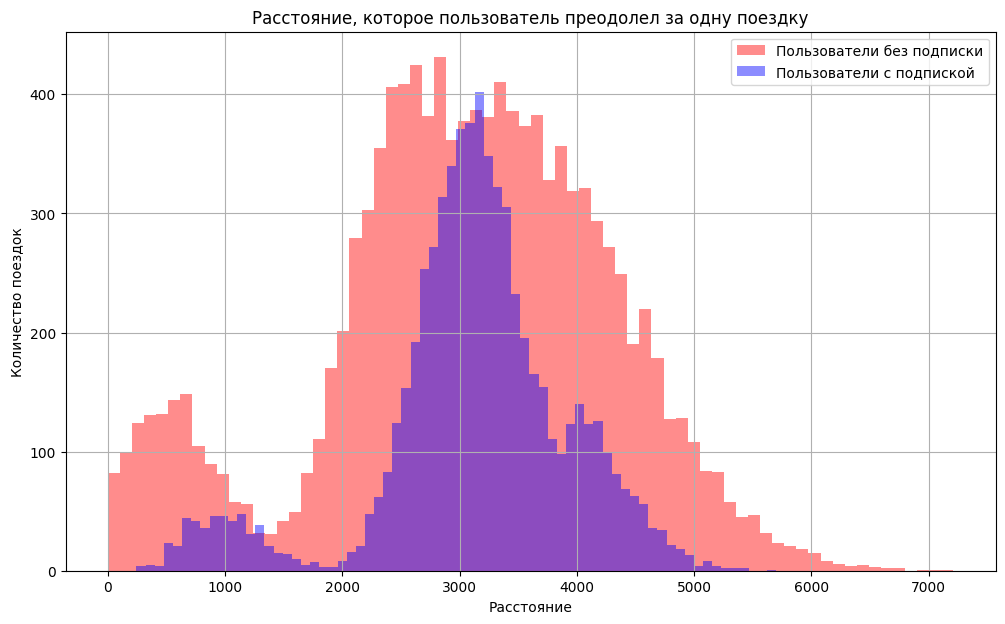

In [126]:
free['distance'].hist(bins=70, alpha=0.45, color='red', figsize=(12,7))
ultra['distance'].hist(bins=70, alpha=0.45, color='blue', figsize=(12,7))

plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.legend(['Пользователи без подписки', 'Пользователи с подпиской'])
plt.show()

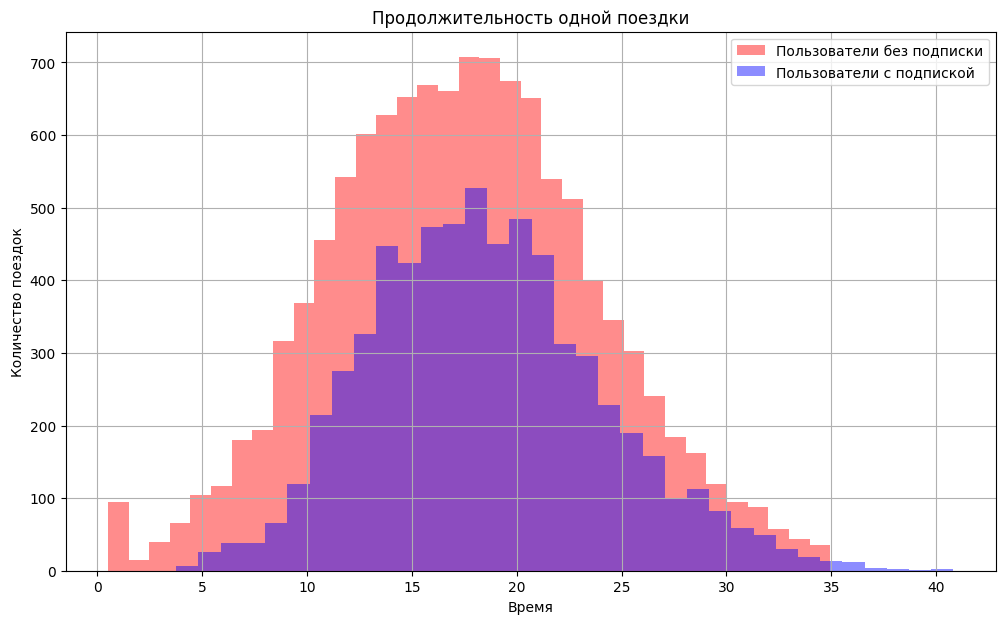

In [127]:
free['duration'].hist(bins=35, alpha=0.45, color='red', figsize=(12,7))
ultra['duration'].hist(bins=35, alpha=0.45, color='blue', figsize=(12,7))

plt.title('Продолжительность одной поездки')
plt.xlabel('Время')
plt.ylabel('Количество поездок')
plt.legend(['Пользователи без подписки', 'Пользователи с подпиской'])
plt.show()

Как бы не было странно, но именно пользователи без подписки чаще пользуются сервисом, чем пользователи с подпиской. Об этом нам говорят графики выше. Само распределение данных у обоих датафреймов практически одинаково, но количество поездок у пользователей без подписки значительно превышает количество поездок у пользователей с подпиской (это можно заметить и по расстоянию, и по времени).

# Шаг 5. Подсчёт выручки

Первоначально округлим время каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости до следующего целого числа:

In [128]:
data['duration'] = np.ceil(data['duration'])

Создаём датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: находим суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Для этого используем сводную таблицу. Также сразу переименуем столбцы и перезапишем индексы, чтобы не было проблем с обращением к данным через двойные индексы:

In [129]:
users = data.pivot_table(index=['user_id', 'date_month'],
                         values=['distance', 'duration', 'name', 'subscription_type'],
                         aggfunc={'distance':'sum', 'duration':'sum', 'name':'count', 'subscription_type':'min'})
users.columns = ['total_distance', 'total_duration', 'count_rides', 'subscription_type']
users = users.reset_index()
users.head(20)

,user_id,date_month,total_distance,total_duration,count_rides,subscription_type
0,1,1,7027.511294,42.0,2,ultra
1,1,4,754.159807,7.0,1,ultra
2,1,8,6723.470560,46.0,2,ultra
3,1,10,5809.911100,32.0,2,ultra
4,1,11,7003.499363,56.0,3,ultra
5,1,12,6751.629942,28.0,2,ultra
6,2,3,10187.723006,63.0,3,ultra
7,2,4,6164.381824,40.0,2,ultra
8,2,6,3255.338202,14.0,1,ultra
9,2,7,6780.722964,48.0,2,ultra


В этот же датафрейм добавляем столбец ***income*** с помесячной выручкой, которую принёс каждый пользователь. Для этого обращаемся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Создаём функцию и применяем к датафрейму по всем строкам.

In [130]:
def income (row):
    if row['subscription_type'] == 'ultra':
        return (row['total_duration'] * 6 + 199)
    else:
        return (row['count_rides'] * 50 + row['total_duration'] * 8)

users['income'] = users.apply(income, axis=1)
users.head(20)

,user_id,date_month,total_distance,total_duration,count_rides,subscription_type,income
0,1,1,7027.511294,42.0,2,ultra,451.0
1,1,4,754.159807,7.0,1,ultra,241.0
2,1,8,6723.470560,46.0,2,ultra,475.0
3,1,10,5809.911100,32.0,2,ultra,391.0
4,1,11,7003.499363,56.0,3,ultra,535.0
5,1,12,6751.629942,28.0,2,ultra,367.0
6,2,3,10187.723006,63.0,3,ultra,577.0
7,2,4,6164.381824,40.0,2,ultra,439.0
8,2,6,3255.338202,14.0,1,ultra,283.0
9,2,7,6780.722964,48.0,2,ultra,487.0


In [131]:
# Код ревьюера
users.groupby('subscription_type')['income'].mean()

subscription_type
free     328.641365
ultra    362.792191
Name: income, dtype: float64

# Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

## Гипотеза №1

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

***Нулевая гипотеза:*** среднее время поездок пользователей из обеих категорий равны.

***Альтернативная гипотеза:*** среднее время поездок пользователей с подпиской больше, чем пользователей без подписки.

Также, в параметре *equal_var* для метода *st.ttest_ind* установим значение *False*, так как у нас разные по размерам выборки (6500 поездок у пользователей с подпиской и более 11500 поездок у пользователей без подписки).

In [132]:
alpha = 0.05 # уровень статистической значимости

duration_ultra = data[data.subscription_type == 'ultra']['duration']
duration_free = data[data.subscription_type == 'free']['duration']

results = st.ttest_ind(duration_ultra, duration_free, equal_var=False, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.1814679253701353e-36
Отвергаем нулевую гипотезу


По результатам проверки делаем вывод: мы можем склоняться к утверждению, что время поездок пользователей с подпиской больше, чем пользователей без подписки.

## Гипотеза №2

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

***Нулевая гипотеза***: расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров.

***Альтернативная гипотеза***: расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 метров.

In [133]:
distance_ultra = data[data.subscription_type == 'ultra']['distance']

distance_of_one_trip = 3130
alpha = 0.05 # уровень статистической значимости


results = st.ttest_1samp(distance_ultra, distance_of_one_trip, alternative='greater')

print('p-значение:', results.pvalue)

# проверяем p-value
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')


p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


Вывод из проверки гипотезы: можем утверждать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, равно или меньше оптимального с точки зрения износа самоката, что говорит нам о бережном использовании и более продолжительном времени безопасной эксплуатации самоката до момента износа.

## Гипотеза №3

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

***Нулевая гипотеза***: помесячная выручка от пользователей из обеих категорий равна.

***Альтернативная гипотеза***: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Также, в параметре *equal_var* для метода *st.ttest_ind* установим значение *False*, так как у нас разные по размерам выборки (больше 4500 строк данных о помесячной выручке у пользователей с подпиской и чуть меньше 6800 строк данных у пользователей без подписки).

In [134]:
alpha = 0.05 # уровень статистической значимости

income_ultra = users[users.subscription_type == 'ultra']['income']
income_free = users[users.subscription_type == 'free']['income']

results = st.ttest_ind(income_ultra, income_free, equal_var=False, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 8.874140893976874e-40
Отвергаем нулевую гипотезу


По результатам проверки гипотезы можем склоняться к тому, что больше выручки приносят пользователи с подпиской, чем без неё.

## Теоретический кейс

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

***Ответ***: в этом случае нам понадобился бы тест для проверки гипотезы о равенстве средних для зависимых (парных) выборок. Наши выборки в данном случае были бы парными, так как используются данные одних и тех же пользователей до и после какого-либо изменения.

В *Python* мы бы применили метод *scipy.stats.ttest_rel()* с двумя параметрами: наборы данных до и после изменения.

# Шаг 7. Распределения

## Задача №1

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Импортируем необходимые библиотеки:

In [135]:
from matplotlib import pyplot as plt
from math import factorial
from math import sqrt
from scipy import stats as st
from scipy.stats import binom

Для решения данной задачи будем использовать аппроксимацию биномиального распределения нормальным, чтобы применить метод *cdf()*.
Далее с помощью этого метода меняем значение параметра N, чтобы получить необходимую вероятность выполнения плана (95%):

In [136]:
p = 0.1 # вероятность продления подписки клиентом
n = 1169 # минимальное количество промокодов

mu = n * p # рассчитываем параметры
sigma = sqrt(mu * (1 - p)) # нормального распределения

distr_norm = st.norm(mu, sigma) # задаем нормальное распределение

result = 1 - distr_norm.cdf(100) # находим вероятность
print(result)

0.9502851068730583


График нашего биномиального распределения:

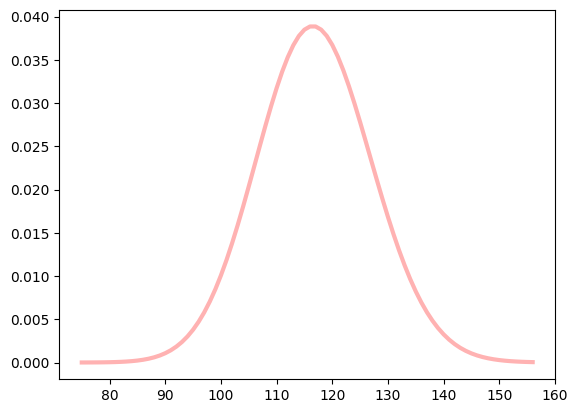

In [137]:
# границы промежутка, в котором будем строить график
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
ax = plt.subplot()
# используем красную линию ширины 3 и прозрачности 0.3
ax.plot(x, binom.pmf(x, n, p), 'r-', lw=3, alpha=0.3,
	      label='вероятности биномиального распределения')

# выводим график
plt.show()

Таким образом, получаем необходимое количество клиентов, которым нужно отправить промокоды, чтобы как минимум 100 клиентов продлило подписку после бесплатного месяца с вероятностью в 95%.

## Задача №2

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

В данном случае также воспользуемся аппроксимацией биномиального распределения нормальным и посчитаем нужную вероятность:

In [138]:
p = 0.4 # вероятность, что клиент откроет уведомление
n = 1000000 # количество планируемой рассылки уведомлений

mu = n * p # рассчитываем параметры
sigma = sqrt(mu * (1 - p)) # нормального распределения

distr_norm = st.norm(mu, sigma) # задаем нормальное распределение

result = distr_norm.cdf(399500) # находим вероятность
print(result)

0.15371708296369768


График биномиального распределения:

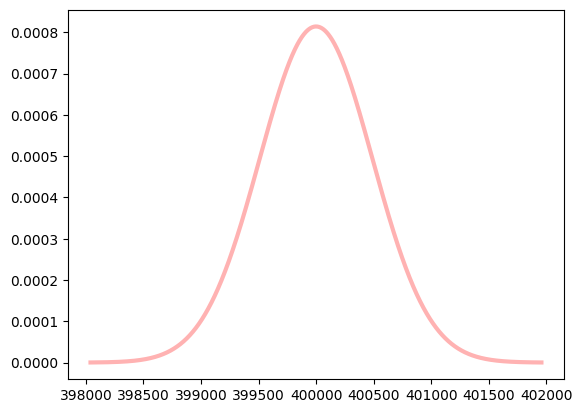

In [139]:
# границы промежутка, в котором будем строить график
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
ax = plt.subplot()
# используем красную линию ширины 3 и прозрачности 0.3
ax.plot(x, binom.pmf(x, n, p), 'r-', lw=3, alpha=0.3,
	      label='вероятности биномиального распределения')

# выводим график
plt.show()

Из расчётов получаем, что вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составляет примерно 15,37%.

# Общий вывод

Данную работу мы выполнили в ***несколько этапов***:
* выгрузили в датафреймы необходимые нам данные;
* провели качественную предобработку (поправили типы данных и избавились от дубликатов в данных);
* провели первоначальный исследовательский анализ:
  * выявили города, в которых находится большинство наших пользователей - *Пятигорск, Екатеринбург и Ростов-на-Дону*;
  * выявили соотношение пользователей с подпиской (*54,4%*) и без неё - (*45,6%*);
  * выяснили ключевой возраст нашей целевой аудитории (*25 лет*);
  * увидели среднюю продолжительность поездок по времени (*15-20 минут*) и расстоянию (*2700 - 3200 метров*).
* объединили данные в один датафрейм и выяснили, что именно пользователи без подписки чаще пользуются нашим приложением;
* провели подсчёт выручки и проверили несколько важных гипотез.

Проделав большую работу, можем сделать несколько ***ключевых итогов*** из проекта:

* время поездок пользователей с подпиской больше, чем пользователей без подписки;
* пользователи с подпиской за одну поездку, равно или не более 3130 метров (оптимальное расстояние, с точки зрения износа самоката);
* больше выручки приносят пользователи с подпиской, чем без неё.

Опираясь на вышеизложенные аргументы, мы можем сделать главный вывод - пользователи с подпиской важны и более выгодны для компании, чем пользователи без неё, поэтому стоит довериться продакт-менеджерам компании и провести несколько акции для увелечения числа пользователей с подпиской.